In [64]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import math


In [65]:
train_data_dir = '/content/drive/MyDrive/Colab Notebooks/archive/Train_Test_Valid/Train'
validation_data_dir = '/content/drive/MyDrive/Colab Notebooks/archive/Train_Test_Valid/valid'
test_data_dir = '/content/drive/MyDrive/Colab Notebooks/archive/Train_Test_Valid/test'

img_width, img_height = 224, 224
batch_size = 32


In [66]:
train_data_pre = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8,1.2],
    channel_shift_range=20,
    fill_mode='nearest'
)

valid_data_pre = ImageDataGenerator(preprocessing_function=preprocess_input)

test_data_pre = ImageDataGenerator(preprocessing_function=preprocess_input)

train_data = train_data_pre.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_data = valid_data_pre.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_data_pre.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 900 images belonging to 6 classes.
Found 39 images belonging to 6 classes.
Found 40 images belonging to 6 classes.


In [67]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.6)(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.7)(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [68]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

training_history = model.fit(
    train_data,
    steps_per_epoch=math.ceil(train_data.samples / batch_size),
    epochs=50,
    validation_data=valid_data,
    validation_steps=math.ceil(valid_data.samples / batch_size),
    callbacks=[early_stopping]
)



Epoch 1/50
29/29 [==============================] - 23s 584ms/step - loss: 2.3990 - accuracy: 0.2478 - val_loss: 1.4794 - val_accuracy: 0.4103
Epoch 2/50
29/29 [==============================] - 16s 568ms/step - loss: 1.7007 - accuracy: 0.4044 - val_loss: 1.1051 - val_accuracy: 0.6154
Epoch 3/50
29/29 [==============================] - 17s 574ms/step - loss: 1.3589 - accuracy: 0.5322 - val_loss: 1.0414 - val_accuracy: 0.6410
Epoch 4/50
29/29 [==============================] - 18s 625ms/step - loss: 1.1656 - accuracy: 0.6067 - val_loss: 0.9903 - val_accuracy: 0.6923
Epoch 5/50
29/29 [==============================] - 17s 583ms/step - loss: 0.9862 - accuracy: 0.6444 - val_loss: 0.9864 - val_accuracy: 0.6923
Epoch 6/50
29/29 [==============================] - 17s 573ms/step - loss: 0.8709 - accuracy: 0.6944 - val_loss: 0.9671 - val_accuracy: 0.6923
Epoch 7/50
29/29 [==============================] - 18s 613ms/step - loss: 0.8039 - accuracy: 0.7156 - val_loss: 0.9281 - val_accuracy: 0.6667

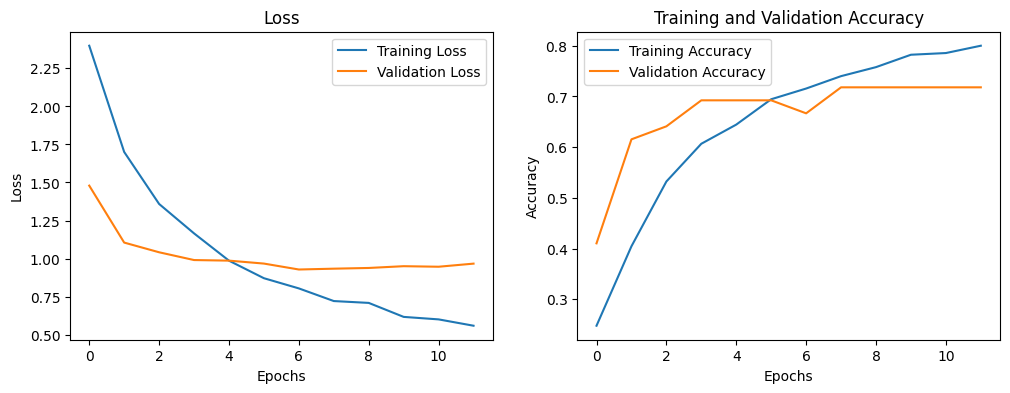

In [69]:
train_data_loss = training_history.history['loss']
valid_data_loss = training_history.history['val_loss']
train_data_acc = training_history.history['accuracy']
valid_data_acc = training_history.history['val_accuracy']

epochs = range(len(train_data_loss))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_data_loss, label='Training Loss')
plt.plot(epochs, valid_data_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_data_acc, label='Training Accuracy')
plt.plot(epochs, valid_data_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [70]:
test_loss, test_accuracy = model.evaluate(test_data)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


2/2 [==============================] - 0s 46ms/step - loss: 0.6071 - accuracy: 0.9000
Test Loss: 0.6070798635482788
Test Accuracy: 0.8999999761581421
